## **Setup**
Call needed packages and load data filepath for Colab.

**Note:** This notebook ingests data downloaded from the Coronawhy dataverse via the notebook [`Dataverse-Colab-Connect.ipynb`](https://colab.research.google.com/drive/1R3QxPTEQNZzItAM_D5pT7n2Yk_JA4I4v#scrollTo=hq4gIQlylCJd).

In [ ]:
#Point to file location
import os
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root = os.getcwd()
download_destination = 'gdrive/My Drive/COVID-19/data'
cwd = os.path.join(root, download_destination)
os.chdir(cwd)
print('Current working directory: ', os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current working directory:  /content/gdrive/My Drive/COVID-19/data


In [ ]:
import spacy
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt

from __future__ import unicode_literals, print_function

import plac
import random
from pathlib import Path
from spacy.util import minibatch, compounding, decaying

from __future__ import unicode_literals, print_function
from spacy.lang.en import English

!pip install pymongo
from pymongo import MongoClient

## **Step 1: Import results obtained from ElasticSearch**
Data can also be found in CoronaWhy's ElasticSearch.  You can download it via Brandon's notebook [here](https://colab.research.google.com/drive/1QWjwZDInL70O_yGwWdlsKqqTpEOLyRQ0#scrollTo=7h1nmpv1WCJH).

Data drawn from this location yields Elasticsearch results from the "More Like This" function.  The function evaluates sentences based on their similarity (BM25 score) to the query phrase ("sample size" in our case).  As I'm not medically well-versed, this method will hopefully +yield a variety of sentences containing information on sample sizes.  We'll then be able to annotate these sentences for the applicable data in the next step.

In [ ]:
#Assumes you've downloaded the results to the google drive 
es_results = pd.read_csv('ES_results.csv')

#Drop 'Unnamed' columns
cols = [c for c in es_results.columns if c.lower() != 'unnamed']
es_results=es_results[cols]

len(es_results)

12870

In [ ]:
es_results.head(3)

,Unnamed: 0,Unnamed: 0.1,cord_uid,language,sentence_id,section,subsection,text,lemma,UMLS,UMLS_IDS,translated,GGP,SO,TAXON,CHEBI,GO,CL,DNA,CELL_TYPE,CELL_LINE,RNA,PROTEIN,DISEASE,CHEMICAL,CANCER,ORGAN,TISSUE,ORGANISM,CELL,AMINO_ACID,GENE_OR_GENE_PRODUCT,SIMPLE_CHEMICAL,ANATOMICAL_SYSTEM,IMMATERIAL_ANATOMICAL_ENTITY,MULTI-TISSUE_STRUCTURE,DEVELOPING_ANATOMICAL_STRUCTURE,ORGANISM_SUBDIVISION,CELLULAR_COMPONENT,PATHOLOGICAL_FORMATION,ORGANISM_SUBSTANCE
0,0,0,h80na6xb,en,h80na6xb10811045,A. Increases,108,Sample size calculation is typically performed...,"['sample', 'size', 'calculation', 'typically',...","['Sample Size', 'Stage', 'size', 'Sample Size'...","['C0242618', 'C1306673', 'C0456389', 'C0242618...",False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,2,ohthcjxc,en,ohthcjxc124752,"Settings, Sample, and Recruitment",12,Sample size was estimated using the sample siz...,"['sample', 'size', 'estimate', 'sample', 'size...","['Sample Size', 'Sample Size', 'Imagery', 'Dis...","['C0242618', 'C0242618', 'C0175631', 'C0231170']",False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,4,hpdl3z6k,it,hpdl3z6k84014508,To Explore Challenges Faced by Nurses Working ...,8401,Sample size‐50,[],[],[],False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


## **Step 2: Annotate and Clean up Testing & Training Datasets**

I set Doccano up on a local server and used the GUI to annotate the dataset I pulled from our ElasticSearch.  Where a quantitative measure of sample size was not available, I identified the relative size ("small", "large", etc.), or the fact that it had not yet been calculated.  In this step, we'll import and clean up that data.

A setup document can be accessed [here](https://docs.google.com/document/d/1HfjhC0VEsIeDu0l6oV0vCzR6SxdvVwq6R5PRn0kWO00/edita).

As for cleanup, the data from Doccano doesn't exactly match the format mentioned on SpaCy's site, so we'll modify the annotated dataset to match. In the end, we want the data to look like this (entity slices are made up):
```
[('The sample size is 15.', {'entities': [(21, 25, 'SampleSize')]}), 
 ('With a sample size of 2000 and a dropout of 18', {'entities': [(21, 25, 'SampleSize'), (89, 91, 'Dropout']}),
```
Additionally, Spacy doesn't seem to like overlapping labels (e.g. `[(15, 18, label_1), (15, 18, label_2)]`, so we'll check for and eliminate those sentences to be sure they don't throw an error when we train our model in Step 3.

In [ ]:
#Import data (need to read in with list comprehension because the json file generated by Doccano results in several dicts in a single json file (which can't otherwise be read))
filename = 'Sentence_Annotations_v3.json1'
data = [json.loads(line) for line in open(filename, 'r')]
len(data)

20214

In [ ]:
#Format data to match SpaCy format
def extract_format_annotations(data, combined=True):
    labeled_data = []
    unlabeled_data = []
    for d in data:
        if d['labels']:
            temp_list = [tuple(i) for i in d['labels']]
            labeled_data.append((d['text'], {'entities':temp_list})) 
        else:
            temp_list = [tuple(i) for i in d['labels']]
            unlabeled_data.append((d['text'], {'entities':temp_list})) 
    if combined==True:
        print('LABELED_DATA: ', len(labeled_data))
        print('UNLABELED_DATA: ', len(unlabeled_data))
        return labeled_data, unlabeled_data
    elif combined==False:
        combined_data = labeled_data + unlabeled_data
        print('COMBINED_DATA: ', len(combined_data))
        return combined_data

#If combined is True
LABELED_DATA, UNLABELED_DATA = extract_format_annotations(data)

#If combined is False
# combined_data = extract_format_annotations(data, combined=False)


LABELED_DATA:  3348
UNLABELED_DATA:  16866


In [ ]:
#Check for duplicates among labeled/unlabeled datasets 
def find_duplicates(dataset_1, *dataset_2):
    if dataset_2:
        for labeled, unlabeled in zip(dataset_1, dataset_2):
            if labeled[0] in unlabeled[0]: #check sentence of one against sentence of another
                print(unlabeled)
    else:
        if dataset_1[0] in dataset_1[0]: #check sentence of one against sentence of another
            print(dataset_1)
                
find_duplicates(LABELED_DATA, UNLABELED_DATA)

In [ ]:
#Visual check on labels
#note that are per sentence, not per entity, so you will see duplicates (this is intentional)
def print_entities(dataset, rows, printout=['all_info', 'labels only']):
    for idx, sent in enumerate(dataset[:rows]): 
        for entity in sent[1]['entities']:
            start = entity[0]
            end = entity[1]
            if printout=='all_info':
                print(idx, ": ", sent, '-->', sent[0][start:end]) #sentences, indices, tags, and entities
            elif printout=='labels':
                print(sent[0][start:end]) #just the labels

print_entities(LABELED_DATA, 10, 'all_info')

0 :  ('Of all enrolled participants, 463 (Of all enrolled participants, 463', {'entities': [(30, 33, 'enrolled')]}) --> 463
1 :  ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89', {'entities': [(7, 10, 'enrolled'), (37, 40, '!enrolled'), (59, 61, '!enrolled'), (29, 31, '!enrolled')]}) --> 100
1 :  ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89', {'entities': [(7, 10, 'enrolled'), (37, 40, '!enrolled'), (59, 61, '!enrolled'), (29, 31, '!enrolled')]}) --> 100
1 :  ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89', {'entities': [(7, 10, 'enrolled'), (37, 40, '!enrolled'), (59, 61, '!enrolled'), (29, 31, '!enrolled')]}) --> 89
1 :  ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89', {'entities': [(7, 10, 'enrolled'), (37, 40, '!enrolled'), (59, 61, '!enrolled'), (29, 31, '!enrolled')]}) --> 89
2 :  ('Of the 2207 enrolled children, 379 (17%) were enrolled in the ICU.', {'entities': [(7, 11, 'enrolled'), (31, 34, '!enrolled')]}) --

      Label counts       
 -----------------------
enrolled :  1437
!enrolled :  2219
enrolled_add :  657
sample_size_add :  122
!sample_size :  949
sample_size :  996
sample_size_subtract :  9
enrolled_subtract :  17
dropout :  32
!dropout :  1




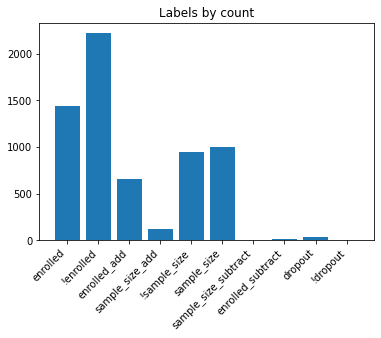

In [ ]:
#Plot label counts

def get_plot_label_counts(dataset):
    counts = defaultdict(int)
    for label in dataset:
        for entity in label[1]['entities']:
            counts[entity[2]] += 1

    #Print results
    print('      Label counts      ', '\n', '-----------------------')
    for label, count in counts.items():
        print(label, ': ', count)

    print('\n')

    #Plot results
    plt.title('Labels by count')
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=45, ha='right')

get_plot_label_counts(LABELED_DATA)

Get other sentences from random papers in MongoDB to intersperse throughout the training dataset.

In [ ]:
#Feed in all sentences from several articles (to check how well it generalizes) --> obtained by MongoDB
# Read-only credentials to CoronaWhy MongoDB service 
mongouser = 'coronawhyguest'
mongopass = 'coro901na'
cordversion = 'v22'

client = MongoClient("mongodb://%s:%s@mongodb.coronawhy.org" % (mongouser, mongopass))
db = client.get_database('cord19')
collection = db[cordversion]

#Define list of paper IDs from which to get sentences
ids = ['000tfenb', '00rk8fb5', '00n9xho8', '011k6mm0', '01o15wd4', 
       '8zchiykl', '5yhe786e', 'zjufx4fo', '2b73a28n', '9785vg6d', 
       't35n7bk9', '6iu1dtyl', 'mcuixluu', 'tvxpckxo', 'sgmk96vr',
       '4k8f7ou1', 'wnnsmx60', 'gdsfkw1b', 'yba7mdtb', 'bbvxu8op']

# MongoDB query by cord_uid
PaperByCordID = {'cord_uid': {"$in": ids}}
metadata = collection.find(PaperByCordID)

#Create a dataframe of results
mongo_df = pd.DataFrame(metadata)
print('Number of papers: ', len(mongo_df))

Number of papers:  20


In [ ]:
#Get text from MongoDB
text = mongo_df.body_rows

sentences = []
for sent in text:
    for s in sent:
        if isinstance(s['text'], str):
            sentences.append(s['text'])
        else:
            [sentences.append(x['text']) for x in s['text']]

#Instantiate sentencizer (used to break up paragraphs into sentences)
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
doc = [nlp(s) for s in sentences]

#Apprend sentences to a new list
result = []
for d in doc:
    result.append(list(d.sents))

#Split out sentences from list of lists
NON_ES_SENTENCES = []
for r in result:
    for x in r:
        d = {'entities': []}
        NON_ES_SENTENCES.append((str(x), d))

print('Number of sentences extracted: ', len(NON_ES_SENTENCES))

Number of sentences extracted:  3725


In [ ]:
#Remove unwanted labels from the dataset
wanted_labels = ['enrolled', '!enrolled', 'enrolled_add', 'sample_size', '!sample_size']

def keep_labels_only(dataset, wanted_labels=wanted_labels):
    LABELED_DATA = []
    for sent, entities in dataset:
        for entity in entities.values():
            labels_dict = {}
            new_ent_list = []
            for start, end, label in entity:
                if label in wanted_labels:
                    new_ent = (start, end, label)
                    new_ent_list.append(new_ent)
            labels_dict['entities'] = new_ent_list
            LABELED_DATA.append((sent, labels_dict))
    return LABELED_DATA

LABELED_DATA = keep_labels_only(LABELED_DATA)
len(LABELED_DATA)

3348

In [ ]:
#Create a dataset with the first 485 enrolled and sample_size labels (so the dataset is balanced)

def get_entity_subset(dataset, entity, num_entities):
    count = 0
    temp = []
    for sent, entities in dataset:
        for ent in entities.values():
            for e in ent:
                if entity in e:
                    temp.append((sent, entities))
                    count += 1
        if count==num_entities:
                        break
                    
    return temp

sample_size_subset = get_entity_subset(LABELED_DATA, 'sample_size', 657) #657 is the min. count among wanted labels
enrolled_subset = get_entity_subset(LABELED_DATA, 'enrolled', 657)

print('sample_size_subset: ', len(sample_size_subset))
print('enrolled_subset: ', len(enrolled_subset))

In [ ]:
#Combine datasets (sample_size_subset, enrolled_subset, UNLABELED_DATA, and NON_ES_SENTENCES)
COMBINED_DATA = LABELED_DATA + NON_ES_SENTENCES
len(COMBINED_DATA)

7073

TRAIN_DATA count:  5658
TEST_DATA count:  1415


Training Data
      Label counts       
 -----------------------
!sample_size :  743
enrolled :  1140
sample_size :  794
!enrolled :  1819
enrolled_add :  513


Test Data
      Label counts       
 -----------------------
sample_size :  202
enrolled :  297
!sample_size :  206
!enrolled :  400
enrolled_add :  144




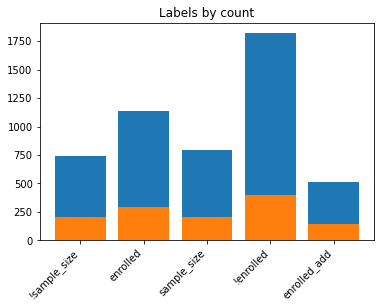

In [ ]:
#Train-test split

from sklearn.model_selection import train_test_split
TRAIN_DATA, TEST_DATA = train_test_split(COMBINED_DATA, 
                                         train_size = 0.8,
                                         test_size = 0.2, 
                                         shuffle=True)
print('TRAIN_DATA count: ', len(TRAIN_DATA))
print('TEST_DATA count: ', len(TEST_DATA))
print('\n')
print('Training Data')
get_plot_label_counts(TRAIN_DATA)

print('Test Data')
get_plot_label_counts(TEST_DATA)

In [ ]:
#Check to see if entities overlap (will cause problem for SpaCy) --> just checks pairs in order.
for sent in TRAIN_DATA:
    if len(sent[1]['entities']) > 1:
        for idx, ent in enumerate(sent[1]['entities'][:-1]):
            if ent[:2] == sent[1]['entities'][idx+1][:2]:
                sent[1]['entities'].remove((ent)) #removes the sentence with duplicate entities
                print(sent) #prints the removed sentence(s)

In [ ]:
#Remove a particularly problematic label
#The code above only removes labels whose ranges are identical, not those whose overlap (which is the problem with this label)
def deduplicate_data(dataset):
    print('Pre-length: ', len(dataset))
    dataset = [sent for sent in dataset if sent[1]['entities'] != [(96, 112, 'sample_size'), (96, 111, 'sample_size')]]      
    print('Post-length:' ,len(dataset))
    return dataset

TRAIN_DATA = deduplicate_data(TRAIN_DATA)
TEST_DATA = deduplicate_data(TEST_DATA)

Pre-length:  5658
Post-length: 5658
Pre-length:  1415
Post-length: 1415


## **Step 3: Use the annotated data to train our spaCy NER model**

Initially, I thought I'd need to retrain a SciSpaCy model or whichever model Brandon used, however, I'm training a blank model here as it's not necessary at the moment that I have the other entities in the sentence identified for the training of this model (I think).

In [ ]:
import spacy
gpu = spacy.prefer_gpu()
print('GPU:', gpu)

GPU: False


In [ ]:
def train(model, training_data, n_epochs=50):
    if model is not None:
       nlp = spacy.load(model)  # load existing spaCy model
       print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
      ner = nlp.create_pipe("ner")
      nlp.add_pipe(ner, last=True)
  # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
        for _, annotations in training_data:
            for ent in annotations.get("entities"):
                ner.add_label(ent[2])
  
        # get names of other pipes to disable them during training
        other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
           # reset and initialize the weights randomly – but only if we're
            # training a new model
            if model is None:
               nlp.begin_training()
            for itn in range(n_epochs):
                random.shuffle(training_data)
                losses = {}
                loss_list = []
                # batch up the examples using spaCy's minibatch
                batch_size = compounding(4.0, 16.0, 1.001)
                batches = minibatch(training_data, size=batch_size)
                #decaying dropout rate
                dropout_rate = decaying(0.6, 0.2, 1e-4)

                for batch in batches:
                    texts, annotations = zip(*batch)
                    nlp.update(
                            texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop= next(dropout_rate),  # dropout - make it harder to memorise data
                            losses=losses,
                        )
                        loss_list.extend(losses)
                print("epoch: {} Losses: {}".format(itn, str(losses)))
    return nlp, loss_list

trained_model, loss_list = train('en', TRAIN_DATA, n_epochs=100)

Loaded model 'en'
epoch: 0 Losses: {'ner': 95535.20692080703}
epoch: 1 Losses: {'ner': 89230.11343661539}
epoch: 2 Losses: {'ner': 87761.30715846877}
epoch: 3 Losses: {'ner': 87141.48022528015}
epoch: 4 Losses: {'ner': 86399.28255449235}
epoch: 5 Losses: {'ner': 86282.94933359593}
epoch: 6 Losses: {'ner': 86036.89302733395}
epoch: 7 Losses: {'ner': 86135.63033331558}
epoch: 8 Losses: {'ner': 85969.47889217007}
epoch: 9 Losses: {'ner': 85761.04729655432}
epoch: 10 Losses: {'ner': 85811.0836211741}
epoch: 11 Losses: {'ner': 85766.05849349477}
epoch: 12 Losses: {'ner': 85950.66133708804}
epoch: 13 Losses: {'ner': 85606.91770935059}
epoch: 14 Losses: {'ner': 85607.31595711038}
epoch: 15 Losses: {'ner': 85491.48072193563}
epoch: 16 Losses: {'ner': 85294.21733540128}
epoch: 17 Losses: {'ner': 85555.79516643286}
epoch: 18 Losses: {'ner': 85152.36822673678}
epoch: 19 Losses: {'ner': 85248.75627876069}
epoch: 20 Losses: {'ner': 85340.1402567327}
epoch: 21 Losses: {'ner': 85381.13241073862}
epoc

In [ ]:
#Save the model to disk
trained_model.to_disk('./sentence_level_model_v7') 

#v1 is all labels
#v2 only includes labels for `enrolled`, `enrolled_add`, and `sample_size`
#v3 is `enrolled` and `sample_size` only
#v4 is v3 with different hyperparameters (smaller starting batch size, fewer epochs, custom decaying dropout rate)
#v5 is v3 plus sentences that don't have any entities (hopefully will enable generalizeability)
#v6 is v3 trained on a balanced(ish) dataset (toughly 500 examples for each label), plus the introduction of negative data --> really poor results (14%)
#v7 is trained on negative labeled data (e.g. 'enrolled' & '!enrolled')

In [ ]:
#Plot loss by epochs here
import matplotlib.pyplot as plt

plt.plot(loss_list)

## **Step 4: Test our trained model**
Now to see how well our model generalizes by applying the model to the `TEST_DATA` dataset (our remaining annotated/labeled data).  We'll then generate statistics used to evaluate the results.

In [ ]:
#Load the trained model
trained_model = spacy.load('./sentence_level_model_v7')

In [ ]:
#Show model prediction examples
def evaluate_model(pretrained_model, test_data):
    labeled_sentences = []
    for test_instance in test_data:
        test_sentence, entities = test_instance        
        test_doc = pretrained_model(test_sentence)
        predicted_entities = [(ent.text, ent.label_) for ent in test_doc.ents]        
        original_entities = [(test_sentence[int(original_entity[0]): int(original_entity[1])], original_entity[2]) \
                             for original_entity in entities['entities']]
        labeled_sentences.append((test_sentence, dict({'entities':list(predicted_entities)})))

        print("--->" + test_sentence)
        print('original entities', original_entities)
        print('predicted entities', predicted_entities, '\n')        

    return labeled_sentences

labeled_sentences = evaluate_model(trained_model, TEST_DATA)

Streaming output truncated to the last 5000 lines.
original entities []
predicted entities [] 

--->13 Characteristics of the enrolled 285 HCP are summarized in Table 2 .
original entities [('285', 'enrolled'), ('2', '!enrolled')]
predicted entities [('285', 'enrolled')] 

--->On the other hand, these proteins might undergo rapid folding right after their synthesis, which interferes with (or hampers) the secretion process.
original entities []
predicted entities [] 

--->From October 2006 to April 2007, 237 pediatric patients affected by ARTI were enrolled in our study.
original entities [('237', 'enrolled'), ('2007', '!enrolled'), ('2006', '!enrolled')]
predicted entities [('237', 'enrolled')] 

--->SARS pathogenesis is less well understood, yet it is a vital issue in the disease management.
original entities []
predicted entities [] 

--->OC43, HKU1, NL63 and 229E are the most common four HCoVs in most regions, circulating worldwide with a detection rate ranging from 1.1 -8.5% and wi

In [ ]:
from spacy.gold import GoldParse
from spacy.scorer import Scorer

def evaluate(ner_model, examples):
    scorer = Scorer()
    for input_, annot in examples:
        # print(input_, '--> ', annot)
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot['entities'])
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

#Evaluate model
results = evaluate(trained_model, TEST_DATA)

In [ ]:
def format_results(results):
    scores_of_interest = {'ents_f':'Named entity F1 score', 
                        'ents_p':'Named entity precision', 
                        'ents_r':'Named entity recall', 
                        'ents_per_type':'Named entity score (breakdown)'
                        }

    score_abbreviation = {'p':'Precision',
                        'r':'Recall',
                        'f':'F1' 
                        }

    #Print out formatted statistics
    print('Overall statistics')
    print('------------------')
    for score_type, score in results.items():
        if (score_type in scores_of_interest) and (score_type!='ents_per_type'):
            print(scores_of_interest[score_type], ': {:.2f}%'.format(score))
        elif score_type=='ents_per_type':
            print('\n')
            print(scores_of_interest[score_type])
            print('------------------------------')
            breakdown = dict(score.items())
            for entity, values in breakdown.items():
                print(' '*4, entity)
                for sub_score_type, sub_score in values.items():
                    print(' '*8, score_abbreviation[sub_score_type], ': {:2f}%'.format(sub_score))
        else:
            continue

format_results(results)

Overall statistics
------------------
Named entity precision : 66.45%
Named entity recall : 38.81%
Named entity F1 score : 49.00%


Named entity score (breakdown)
------------------------------
     sample_size
         Precision : 79.874214%
         Recall : 65.128205%
         F1 : 71.751412%
     enrolled_add
         Precision : 46.875000%
         Recall : 46.153846%
         F1 : 46.511628%
     enrolled
         Precision : 67.551622%
         Recall : 83.576642%
         F1 : 74.714519%
     !sample_size
         Precision : 0.000000%
         Recall : 0.000000%
         F1 : 0.000000%
     !enrolled
         Precision : 0.000000%
         Recall : 0.000000%
         F1 : 0.000000%


# __Step 5: Run unlabeled data through the model__ #

And now we'll apply our model to our unlabeled data in order to identify sample sizes in this dataset!

## With non-ES sentences

Because we got our subsample of sentences from ElasticSearch, our validation and test datasets were also "handpicked".  So, here, we take text from a few of the papers test our model against that.

In [ ]:
final_results = evaluate_model(trained_model, NON_ES_SENTENCES)
# UNLABELED_DATA[:10]

Streaming output truncated to the last 5000 lines.
original entities []
predicted entities [] 

--->Additionally, the infectivity of mild cases appears as an important parameter as well.
original entities []
predicted entities [] 

--->Rapid contact tracing in ring vaccination may play an important role in suppressing the epidemic, since the longer it takes to trace a contact, the less likely the vaccine is to be efficacious, and the more opportunities the infected individual may have to transmit disease before they are finally located, isolated, and vaccinated if appropriate.
original entities []
predicted entities [] 

--->We illustrate this possibility in Figure 6 by examining the same scenario we showed earlier in Figure  3A (e.g. households of size 4, workplace/social groups of size 8, 95% of household contacts traceable, 80% of workplace/social groups traceable, an average time to infection for a household contact of an infective given by 0.2 days).
original entities []
predicted

In [ ]:
print('Total sentences in MongoDB dataset: ', len(final_results))

counter = 0
for result in final_results:
    if result[1]['entities']:
        print(result[0], '\n', [i for i in result[1]['entities']])
        counter += 1

print('Total predictions made: ', counter)

Total sentences in MongoDB dataset:  3725
Results: 78 (2.37%; 95%CI 1.8-2.8%) out of 3298 nasopharyngeal swabs specimens were found to be positive for OC43 (36;1.09%), HKU1 (34; 1.03%), NL63 (6; 0.18%) and 229E (2;0.01%). 
 [('78', 'enrolled')]
Viral nucleic acids were extracted from 200 μL respiratory samples using MagNA pure 96 DNA with Viral NA small volume kit (Roche) and EZ1 virus Mini kit V2.0 (Qiagen) according to the manufacturer's instructions. 
 [('small', 'sample_size')]
4B for the bare GCE (I pa ¼ 4.617 mA, E pa ¼ 0.276 V for myricetin, and I pa ¼ 1.316 mA, E pa ¼ 0.432 V for rutin) provided very small current signals. 
 [('small', 'sample_size')]
Results: Eight patients were admitted, with ages ranging from 55 to 65 years old. 
 [('Eight', 'enrolled')]
There were five patients with solid organ tumors (62.5%) and three with hematological malignancies (37.5%). 
 [('five', 'enrolled')]
However, most patients developed a more extensive and progressive In all the eight patients


# **Comparing annotated sentences in the same paper** 

Since we were annotating individual sentences, even with a good F1 score, I wanted to see some of the results as grouped by paper.  The following code does exactly that, in an effort to understand how many annotations are being made per paper on a subject such as `enrollment` counts.

In [ ]:
#Keep only the columns we need
es_results = es_results.iloc[:,2:11]

In [ ]:
#Transform our results into a dataframe for easy merging
f = pd.DataFrame([[k, v.values()] for k, v in final_results], columns=['sentence', 'entities'])
f.head()

,sentence,entities
0,The Nomination Network shown in Fig. 4 highlig...,([])
1,Enrolled:,([])
2,[{'text': 'were enrolled.,([])
3,Although only 45% of eligible patients were en...,([])
4,The age and sex of the enrolled children were ...,([])


In [ ]:
#Merge annotated data with original dataframe (so as to get cord_uids for each sentence)
temp = es_results.merge(f, on='sentence', how='right')
print('Total values merged: ', temp.entities.value_counts().sum())

#drop sentences without entity labels
temp = temp.dropna(subset=['entities'])
print('Total non-null values: ', len(temp)) #"null" being different than "([])"

In [ ]:
#drop entities with value '([])' (e.g. non-annotated sentences)
for idx, entity in enumerate(temp['entities']):
    entity = tuple(entity)[0]
    if not entity:
        temp.drop(idx, inplace=True)

print('Number of annotated sentences:', len(temp))

Number of annotated sentences 809


In [ ]:
#keep only rows with more than one annotated sentence
temp = temp.groupby('cord_uid').filter(lambda x: len(x)>1) 
print('Multi-sentence length: ', len(temp))

#Sort the results and reset the indices
temp.sort_values(by='cord_uid', inplace=True)
temp.reset_index(drop=True, inplace=True)

#Display only the data that we need
# pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
temp[['cord_uid', 'sentence', 'entities']]

Multi-sentence length:  361


,cord_uid,sentence,entities
0,0aytlpyv,"Inpatients were enrolled and samples obtained within a median of 16 hours (interquartile range [IQR], 9–23 hours) of hospitalization.","([([, enrolled_1)])"
1,0aytlpyv,"From February 2015 to March 2017, we enrolled 150 children <2 years of age with RSV infection.","([(2015, enrolled_1), (150, enrolled_1)])"
2,0gzaonz9,Methods: All TB patients diagnosed at Sotiria and Sismanoglion Hospitals during an 18-month period were prospectively enrolled.,"([(18-month, enrolled_1)])"
3,0gzaonz9,One hundred four unselected and consecutive patients who underwent renal allograft transplantation in 2002 at Nantes Hospital were enrolled.,"([(One hundred four, enrolled_1)])"
4,0is6op3d,Methods: Sixty-two patients who had ferritin level data available at cGVHD diagnosis were enrolled into this study.,"([(Sixty-two, enrolled_1)])"
5,0is6op3d,"Results: 30 adult patients (median age 38 years, range 20-63, 13 female, 17 male) were enrolled in 7 centers.","([(30, enrolled_1)])"
6,0is6op3d,Methods: We enrolled 661 consecutive adult ALL patients who underwent transplantation from 1995 to 2015 in their first remission (CR1).,"([(661, enrolled_1)])"
7,0is6op3d,"Results: Fifty patients enrolled between 2011 and 2017 at 11 UK centres, the median age was 60 (19-70).","([(Fifty, enrolled_1)])"
8,0is6op3d,"Results: Of the enrolled 60 patients, there were 4 drop-outs due to medical reason or patientÂ´s will.","([(60, enrolled_1)])"
9,0is6op3d,"In total, 9 patients, 3 each for 3 doses of plerixafor, were enrolled and underwent allogeneic HSCT.","([(9, enrolled_1)])"


In [ ]:
#Basic imports
!pip install ijson
import ijson
from itertools import islice, chain
#Creating my chunks generator
def chunks(iterable, size):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))

#Reading in the JSON and creating chunks
def read_big_json(f, chunk_size=10000):
  obs = ijson.items(f, 'item')
  return chunks(obs,chunk_size)

#Wrapper for the above
def preprocess_chunk(original_fun):
  def wrapper(c):
    l=[]
    for el in c:
      l.append(el)
    df = pd.DataFrame(l)
    return original_fun(df)
  return wrapper

#My custom function is returndf which I've decorated with preprocess_chunk
@preprocess_chunk
def returndf(df):
  return df

In [ ]:
#Reading in my chunks (file generation from notebook linked above)
f = open('v9text.json')
myfile = read_big_json(f,10000)

In [ ]:
import pandas as pd
#Just checking the first 3 Dataframes that are created. Note: The file needs to be open for this to work
l=[]
c=0
for chunk in myfile:
    l.append(returndf(chunk))
    c+=1
    if (c==100):
        break

df = pd.concat(l)
df.info()